#### Assumptions:
1. The following quantity is fixed : FUND COST = 0.023, RATIO = 1/100, UNIT = 10000
2. Assume CBBC products are held for one-period (1 month = 21 working days)
3. Set strike 3%-close/ 12%-far deviate from spot price. Call level is 0.8%-close/ 3.2%-far from stike (Specified CBBC products may not exist in market)
4. For each stocks they have 4 CBBC products:
    - Bull with close strike
    - Bull with far strike
    - Bear with close strike
    - Bear with far strike


#### Procedures:
1. Select stocks and CBBC
2. Simulate daily stocks return by Monte Carlo
3. Get simulated CBBC returns from simulated daily stocks return
4. Histogram for simulated return
5. Get covariance matrix and mean estimate from the simulated statistics

#### 08/12/2018 Updated
1. Using 1 year as historical data
2. Histogram for simulated return
3. Adjust strike and call level
    - For weekly, set strike to be closer (3%)
    - For monthly, set strike to be further (12%)
4. Weekly return and monthly return
5. Impute historical missing data by mean

#### 10/12/2018 Updated
1. Pull 1 year data from 2017/1/1 to 2017/12/31

In [23]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import abupy
from collections import defaultdict

### 0. CONSTANT

In [24]:
FUND = 0.023
RATIO = 1/100
UNIT = 10000

### 1. ACQUIRE DATA AND SPEC

In [25]:
def get_cost(spot_price, strike, position, fund = FUND, ratio = RATIO, unit = UNIT):
    if position == 'long':
        init_cost = ((spot_price - strike) * ratio + fund) * unit
        return init_cost
    elif position == 'short':
        init_cost = ((strike - spot_price) * ratio + fund) * unit
        return init_cost

In [26]:
# e.g end_data = '2017-12-31'
def get_stock_hist(symbol_list, yr_n, end_date):
    hist_data = abupy.ABuSymbolPd.make_kl_df(symbol_list, n_folds= yr_n, end = end_date)
    return hist_data

In [27]:
def get_CBBC_info(symbol_list, hist_data, time_horizon):
    cbbc_info = defaultdict()
    
    # For weekly return, set strike to be +-3% from spot, call level to be +-0.8% from strike
    if time_horizon == 'weekly':
        strike_load = 0.03
        call_load = 0.008
    # For monthly return, set strike to be +-12% from spot, call level to be +-3.2% from strike
    elif time_horizon == 'monthly':
        strike_load = 0.12
        call_load = 0.032
    
    for symbol in symbol_list:
        sub_info = defaultdict()    
        # Create bull contracts spec
        # Use the latest close price as spot price
        spot_price = hist_data[symbol].iloc[-1][0]
        lng_strike = spot_price * (1 - strike_load)
        lng_call = lng_strike * (1 + call_load)
        lng_cost = get_cost(spot_price, lng_strike, 'long')
        lng_key = 'bull_' + time_horizon
        sub_info[lng_key] = {'spot': spot_price,  'strike': lng_strike, 'call': lng_call, 'init_cost': lng_cost}
        # Create bear contracts spec
        sht_strike = spot_price * (1 + strike_load)
        sht_call = sht_strike * (1 - call_load)
        sht_cost = get_cost(spot_price, sht_strike, 'short')
        sht_key = 'bear_' + time_horizon
        sub_info[sht_key] = {'spot': spot_price,  'strike': sht_strike, 'call': sht_call, 'init_cost': sht_cost}
        
        cbbc_info[symbol] = sub_info
    return cbbc_info

In [28]:
# HK00700: Tecent, HK00066: MTR, HK00016: Sun Hung Kai Properties
symbol_list = ['hk00700', 'hk00066', 'hk00016']
hist_data = get_stock_hist(symbol_list, 1, end_date =  '2017-12-31')
cbbc_info = get_CBBC_info(symbol_list, hist_data, time_horizon = 'weekly')

Box(children=(Text(value='pid=2269 begin work'), FloatProgress(value=0.0)))

### 2. SIMULATION

In [58]:
# Simulate one movement path for stock price (not return)
# Weekly = 5, Monthly = 20
# input a panel data. Item = stock index
# Return: rand_cum_df (time-series simulated stock price for all stocks)
# Return: rand_ret_df (time-series simple cumulative return for all stocks)
def Stocks_Sim(hist_data, time_horizon):
    if time_horizon == 'weekly':
        period = 5
    elif time_horizon == 'monthly':
        period = 20
    # Get cumulative return
    symbol_list = list(hist_data.items)
    # Set up a dataframe with rows = time series return, columns = stock index
    ret_df = pd.DataFrame({symbol:hist_data[symbol]['p_change'] for symbol in symbol_list})
    # Imput ret_df by its mean
    ret_df = ret_df.fillna(ret_df.mean())
    ret_df = 1 + (ret_df/ 100)
    # Bootstrap resampling 
    rand_ret_df = ret_df.sample(period)
    # Get time-series simulated cumulative return for all stocks
    rand_cum_ret_df = rand_ret_df.cumprod()
    rand_cum_price_df = rand_cum_ret_df.copy()
    # Convert to net return in %
    rand_cum_ret_df = (rand_cum_ret_df - 1) * 100
    for symbol in symbol_list:
        # Get time-series simulated stock price for all stocks
        # Use the latest close prices * simulated cumulative returns
        spot_price = hist_data[symbol].iloc[-1][0] 
        rand_cum_price_df[symbol] = spot_price * rand_cum_price_df[symbol]
        #print('{} spot price = {}'.format(symbol, spot_price))
    return rand_cum_ret_df, rand_cum_price_df

In [59]:
def CBBC_End_Return(rand_cum_df, cbbc_info):
    cbbc_keys = list(cbbc_info.keys())
    cbbc_ret_dict = dict()
    for symbol in cbbc_keys:
        for product in cbbc_info[symbol].keys():
            # Get simulated payoff for bull contracts at the end
            if 'bull' in product:
                # If call level is touched, set payoff = 0
                if np.sum(rand_cum_df[symbol] <= cbbc_info[symbol][product]['call']):
                    payoff = 0
                else:
                    ult_price = rand_cum_df[symbol][-1]
                    strike = cbbc_info[symbol][product]['strike']
                    mult = RATIO * UNIT
                    payoff = (ult_price - strike) * mult
            # Get simulated payoff for bear contracts at the end
            elif 'bear' in product:
                # if call level is touched, set payoff = 0
                if np.sum(rand_cum_df[symbol] >= cbbc_info[symbol][product]['call']):
                    payoff = 0
                else:
                    ult_price = rand_cum_df[symbol][-1]
                    strike = cbbc_info[symbol][product]['strike']
                    mult = RATIO * UNIT
                    payoff = (strike - ult_price) * mult
            # Get simulated return at the end
            ret = (payoff / cbbc_info[symbol][product]['init_cost'] - 1) * 100
            name = symbol + '_' + product
            cbbc_ret_dict[name] = ret
    return cbbc_ret_dict

# By default simulation number = 5000
# 1 row = a one-period ultimate return
def MonteCarlo_Sim(hist_data, cbbc_info, time_horizon, sim_n = 5000):
    rows = dict()
    for i in range(sim_n):
        rand_cum_ret_df, rand_cum_price_df = Stocks_Sim(hist_data, time_horizon = time_horizon)
        cbbc_ret_dict = CBBC_End_Return(rand_cum_price_df, cbbc_info)
        # Embed stock ultimate return on cbbc_ret_dict
        symbol_list = list(hist_data)
        for symbol in symbol_list:
            cbbc_ret_dict[symbol] = rand_cum_ret_df[symbol][-1]
        sim_key = 'sim_' + str(i)
        rows[sim_key] = cbbc_ret_dict
    sim_df = pd.DataFrame.from_dict(rows, orient='index')
    sim_df = sim_df.reindex_axis(sorted(sim_df), axis=1)
    return sim_df

In [31]:
sim_df = MonteCarlo_Sim(hist_data, cbbc_info, time_horizon = 'weekly')

In [32]:
sim_df

,hk00016,hk00016_bear_weekly,hk00016_bull_weekly,hk00066,hk00066_bear_weekly,hk00066_bull_weekly,hk00700,hk00700_bear_weekly,hk00700_bull_weekly
sim_0,-2.6314,18.2132,-100.0000,-3.8818,-14.2115,-100.0000,3.1079,-100.0000,71.2581
sim_1,1.0905,-100.0000,-14.1339,-0.9661,-50.5582,-74.6460,-4.6703,115.0652,-100.0000
sim_10,-3.1793,29.7144,-100.0000,-1.3037,-46.3507,-78.8534,3.7332,-100.0000,88.7913
sim_100,-0.9355,-17.3879,-56.6624,-0.8063,-52.5507,-72.6534,3.5536,-100.0000,83.7552
sim_1000,2.2749,-100.0000,10.7296,2.6200,-100.0000,-29.9412,-1.5101,26.4563,-58.2243
sim_1001,2.5029,-100.0000,15.5152,-1.6264,-42.3273,-82.8769,-4.0825,98.5838,-100.0000
sim_1002,1.8310,-75.4600,1.4098,2.8533,-100.0000,-27.0324,-2.6734,59.0745,-100.0000
sim_1003,-0.3588,-29.4943,-44.5560,-1.5484,-43.2999,-81.9042,2.0345,-100.0000,41.1595
sim_1004,1.5955,-70.5167,-3.5335,-0.7187,-53.6426,-71.5615,1.2061,-100.0000,17.9335
sim_1005,0.9207,-56.3523,-17.6979,1.5273,-81.6414,-43.5627,-2.8437,63.8503,-100.0000


### 3. HISTOGRAM FOR SIMULATED RETURN

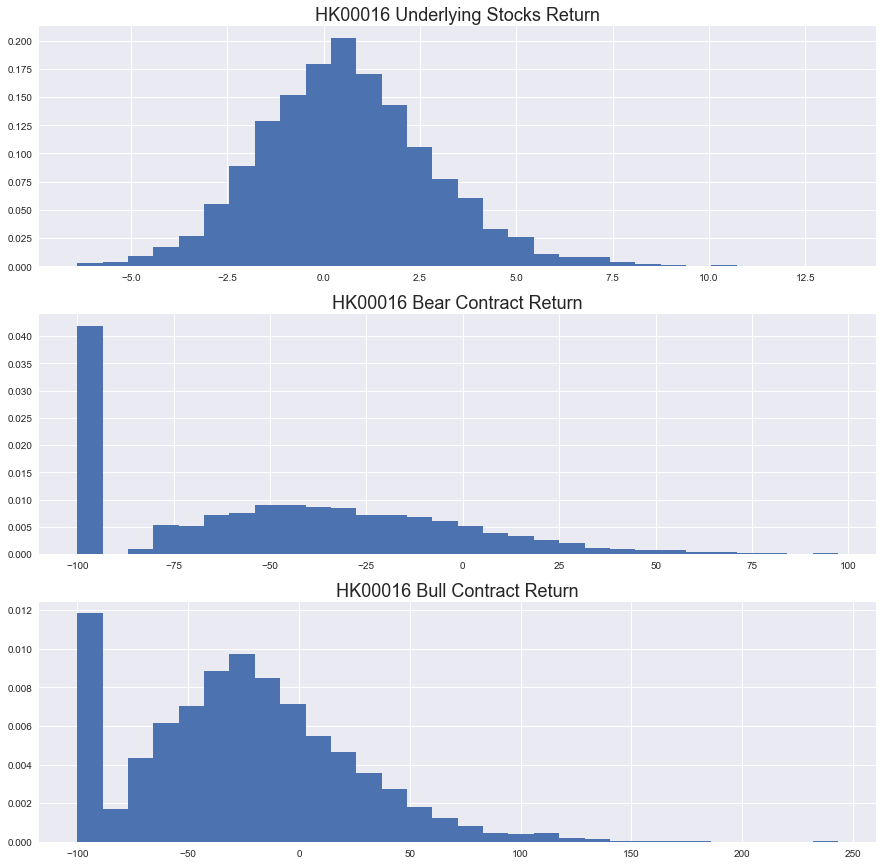

In [33]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows = 3, ncols=  1, figsize = (15, 15))

ax1.hist(sim_df['hk00016'], normed = True, bins = 30)
ax1.set_title('HK00016 Underlying Stocks Return', fontdict = {'fontsize': 18})
ax2.hist(sim_df['hk00016_bear_weekly'], normed = True, bins = 30)
ax2.set_title('HK00016 Bear Contract Return', fontdict = {'fontsize': 18})
ax3.hist(sim_df['hk00016_bull_weekly'], normed = True, bins = 30)
ax3.set_title('HK00016 Bull Contract Return', fontdict = {'fontsize': 18});

### 4. MAIN RUN FOR ESTIMATING MEAN AND COVARIANCE

In [34]:
# symbol_list: stock identifier
# yr_n: number of year to be extracted as historical data
# time_horizon: weekly or monthly as one-period
# Output is mean and covariance as dataframe (in %)
def Get_MeanCovariance(symbol_list, yr_n, time_horizon, end_date):
    hist_data = get_stock_hist(symbol_list, yr_n, end_date = end_date)
    cbbc_info = get_CBBC_info(symbol_list, hist_data, time_horizon = time_horizon)
    sim_df = MonteCarlo_Sim(hist_data, cbbc_info, time_horizon = time_horizon)
    mean = sim_df.mean()
    cov_mat = sim_df.cov()
    return mean, cov_mat

In [60]:
# 2017 1-year historical data
symbol_list = ['hk00700', 'hk00066', 'hk00016']
mean_2017, cov_mat_2017 = Get_MeanCovariance(symbol_list, yr_n = 1, time_horizon = 'monthly', end_date = '2017-12-31')

Box(children=(Text(value='pid=2269 begin work'), FloatProgress(value=0.0)))

In [61]:
# 2018 1-year historical data
# ** DONT SET end_date TO BE TODAY, SET ONE DAY EARLIER 
symbol_list = ['hk00700', 'hk00066', 'hk00016']
mean_2018, cov_mat_2018 = Get_MeanCovariance(symbol_list, yr_n = 1, time_horizon = 'monthly', end_date = '2017-12-08')

Box(children=(Text(value='pid=2269 begin work'), FloatProgress(value=0.0)))

In [62]:
mean_2017

hk00016                  2.5037
hk00016_bear_monthly   -33.2196
hk00016_bull_monthly     5.3135
hk00066                  1.7049
hk00066_bear_monthly   -40.1128
hk00066_bull_monthly   -20.3101
hk00700                  6.8541
hk00700_bear_monthly   -59.3128
hk00700_bull_monthly    49.5726
dtype: float64

In [63]:
mean_2018

hk00016                  1.4036
hk00016_bear_monthly   -25.3071
hk00016_bull_monthly    -3.7244
hk00066                  1.4534
hk00066_bear_monthly   -39.0496
hk00066_bull_monthly   -21.9672
hk00700                  6.3356
hk00700_bear_monthly   -55.6782
hk00700_bull_monthly    45.0357
dtype: float64

In [64]:
cov_mat_2017

,hk00016,hk00016_bear_monthly,hk00016_bull_monthly,hk00066,hk00066_bear_monthly,hk00066_bull_monthly,hk00700,hk00700_bear_monthly,hk00700_bull_monthly
hk00016,20.3490,-157.1391,148.4690,3.9954,-24.6170,23.9035,7.2906,-48.5280,59.3208
hk00016_bear_monthly,-157.1391,1289.5984,-1146.3596,-30.9005,190.6567,-185.3879,-55.1758,372.6983,-449.0022
hk00016_bull_monthly,148.4690,-1146.3596,1085.2273,29.1030,-179.3282,174.0707,53.4730,-356.0745,435.1139
hk00066,3.9954,-30.9005,29.1030,17.1465,-104.3038,107.8772,3.6734,-23.0928,30.3455
hk00066_bear_monthly,-24.6170,190.6567,-179.3282,-104.3038,648.3677,-655.2278,-22.3955,140.3868,-185.0343
hk00066_bull_monthly,23.9035,-185.3879,174.0707,107.8772,-655.2278,699.4225,20.3257,-124.6461,168.1369
hk00700,7.2906,-55.1758,53.4730,3.6734,-22.3955,20.3257,45.8096,-274.8023,369.5466
hk00700_bear_monthly,-48.5280,372.6983,-356.0745,-23.0928,140.3868,-124.6461,-274.8023,2197.4438,-2226.7698
hk00700_bull_monthly,59.3208,-449.0022,435.1139,30.3455,-185.0343,168.1369,369.5466,-2226.7698,3009.8767


In [65]:
cov_mat_2018

,hk00016,hk00016_bear_monthly,hk00016_bull_monthly,hk00066,hk00066_bear_monthly,hk00066_bull_monthly,hk00700,hk00700_bear_monthly,hk00700_bull_monthly
hk00016,19.4128,-148.3248,141.6888,4.4270,-27.6256,25.9984,6.7662,-43.5252,54.8984
hk00016_bear_monthly,-148.3248,1185.5345,-1082.0331,-33.8111,211.3721,-199.0382,-51.1372,331.6944,-415.2447
hk00016_bull_monthly,141.6888,-1082.0331,1039.3097,32.3290,-201.6556,189.8296,49.2619,-317.3401,399.4743
hk00066,4.4270,-33.8111,32.3290,18.0346,-110.6807,112.2986,4.1739,-26.0413,34.6815
hk00066_bear_monthly,-27.6256,211.3721,-201.6556,-110.6807,700.2408,-688.0312,-26.0626,162.3971,-216.5442
hk00066_bull_monthly,25.9984,-199.0382,189.8296,112.2986,-688.0312,720.3498,22.8485,-141.6329,190.3369
hk00700,6.7662,-51.1372,49.2619,4.1739,-26.0626,22.8485,45.4359,-281.1276,367.8558
hk00700_bear_monthly,-43.5252,331.6944,-317.3401,-26.0413,162.3971,-141.6329,-281.1276,2264.7335,-2288.0608
hk00700_bull_monthly,54.8984,-415.2447,399.4743,34.6815,-216.5442,190.3369,367.8558,-2288.0608,3020.8041
